# Advanced Guide to `caskade`

The beginners guide layed out the basics of constructing simulators in `caskade`, now we will present the powerful capabilities and techniques that let you easily and efficiently perform complex analyses. The order of these techniques has no particular meaning, so you may search for points of interest or scan through for relevant sections. 

In [1]:
import torch
import caskade as ckd
from time import time, sleep

In [2]:
class Gaussian(ckd.Module):
    def __init__(self, name, x0=None, y0=None, q=None, phi=None, sigma=None, I0=None):
        super().__init__(name)
        self.x0 = ckd.Param("x0", x0) # position
        self.y0 = ckd.Param("y0", y0)
        self.q = ckd.Param("q", q) # axis ratio
        self.phi = ckd.Param("phi", phi) # orientation
        self.sigma = ckd.Param("sigma", sigma) # width
        self.I0 = ckd.Param("I0", I0) # intensity

    @ckd.forward
    def _r(self, x, y, x0=None, y0=None, q=None, phi=None):
        x, y = x - x0, y - y0
        s, c = torch.sin(phi), torch.cos(phi)
        x, y = c * x - s * y, s * x + c * y
        return (x ** 2 + (y * q) ** 2).sqrt()
    
    @ckd.forward
    def brightness(self, x, y, sigma=None, I0=None):
        return I0 * (-self._r(x, y)**2 / sigma**2).exp()
    
class Combined(ckd.Module):
    def __init__(self, name, first, second):
        super().__init__(name)
        self.first = first # Modules are automatically registered
        self.second = second

    @ckd.forward
    def brightness(self, x, y):
        return self.first.brightness(x, y) + self.second.brightness(x, y)

## Ways of accessing Param values

When running a simulation there are several ways to access the value of a `Param` object, here is a mostly complete listing.

In [3]:
class TryParam(ckd.Module):
    def __init__(self, submod):
        super().__init__()
        self.x = ckd.Param("x", 1.0)
        self.y = ckd.Param("y", 2.0)
        self.submod = submod

    @ckd.forward
    def test_access(self, a, x, k=1, y=None):
        # Regular function attribute, is not a caskade object and so behaves normally
        total = a
        total += k

        # Getting values from Param objects
        total += x ** 2 # as arg of function (preferred)
        total += y ** 2 # as kwarg of function (preferred)
        total += self.x.value ** 2 # by attribute (allowed but discouraged)
        total += self.submod.I0.value ** 2 # by attribute of submod (allowed but may indicate inefficient code)

        # Modifying values of Param objects
        x = 3.0 # locally modify param value (allowed)
        total += x ** 2 # use modified value, will not change the param value globally
        total += self.submod.brightness(0,0, sigma=2.0) # call module with modified param value, only affects this call (allowed)
        self.x.value = 4.0 # modify param value globally (explicitly forbidden)
        return total
    
G = Gaussian("G", x0=5, y0=5, q=0.5, phi=0.0, sigma=1.0, I0=1.0)
T = TryParam(G)

try:
    T.test_access(0.0)
except ckd.ActiveStateError as e:
    print("Caught ActiveStateError:", e)

Caught ActiveStateError: Cannot set value of parameter x while active


## Call function with internally modified param value

A caskade simulator often is build of nested modules that call each others functions. Sometimes one may wish to call a function but with a different value for one of the Params than what has been given in the input (for example when computing a reference for comparison). Here we will show how to do this kind of local Param modification. This is also covered in [Ways of accessing Param values](#ways-of-accessing-param-values).

In [4]:
class TryModify(ckd.Module):
    def __init__(self, submod):
        super().__init__()
        self.submod = submod
        self.newval1 = torch.tensor(2.0)
        self.newval2 = torch.tensor(3.0)

    @ckd.forward
    def test_modify(self):
        init = self.submod.brightness(0,0) # call with original param values
        mod = self.submod.brightness(0,0, sigma=self.newval1) # call with modified param value
        with ckd.OverrideParam(self.submod.sigma, self.newval2):
            othermod = self.submod.brightness(0,0) # call with temporarily modified param value
        assert init != mod
        assert init != othermod
        assert mod != othermod
        print("See, they are all different!")
        return init, mod, othermod
    
G = Gaussian("G", x0=5, y0=5, q=0.5, phi=0.0, sigma=1.0, I0=1.0)
T = TryModify(G)
print(T.test_modify())

See, they are all different!
(tensor(2.6810e-14), tensor(0.0004), tensor(0.0310))


## Reparametrize a Module

Sometimes it makes sense to write a module and its functions using a particular parametrization, but on some occasions or for user interpretation it should be given in another parametrization. For example, it may be easier to write some model in cartesian coordinates, but for users the polar coordinates are easier to interpret. 

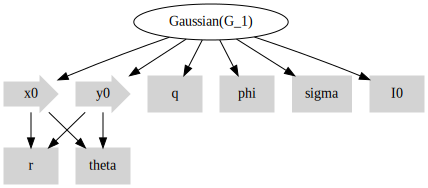

In [5]:
G = Gaussian("G", x0=5, y0=5, q=0.5, phi=0.0, sigma=1.0, I0=1.0) # default in cartesian coordinates
r = ckd.Param("r", 1.0) # radius
theta = ckd.Param("theta", 0.0) # angle
G.x0 = lambda p: p.r.value * torch.cos(p.theta.value)
G.x0.link(r)
G.x0.link(theta)
G.y0 = lambda p: p.r.value * torch.sin(p.theta.value)
G.y0.link(r)
G.y0.link(theta)

G.graphviz()

## Add meta data to a Param or Module

Sometimes it is very useful to carry along some extra data right next to your params. For example, you may want to keep track of the uncertainty of a param value. The best way to do this is by tacking on attributes to the `meta` container in a `Param`. This is essentially an empty class which you may then build on however you like. Anything you do to this object is guaranteed not to interfere with `caskade` stuff. Similarly, making attributes with the `meta_` prefix is guaranteed not to interfere with `caskade` stuff.

In [6]:
p = ckd.Param("p", 1.0) 

p.meta.extra_info = 42 # add attribute to meta container (preferred)
p.meta_extra_info = 42 # add attribute with "meta_" prefix (allowed)
p.extra_info = 42 # add attribute directly to Param object (allowed but discouraged due to potential conflicts)

## Break up a Param Tensor

Sometimes a `Param` value is naturally a multi-component tensor, but we only wish for part of it to be dynamic. This can be accomplished by creating new params and linking appropriately.

Original x tensor tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Rebuilt x tensor tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


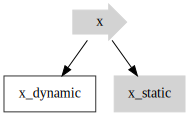

In [7]:
# This is the param we plan to use
x = ckd.Param("x", torch.arange(10)) # param has 10 elements
print("Original x tensor", x.value)

# These are sub params for the broken primary param
x_dynamic = ckd.Param("x_dynamic", torch.arange(3)) # want first three elements to be dynamic
x_dynamic.to_dynamic()
x_static = ckd.Param("x_static", torch.arange(3,10)) # want last seven elements to be static

# This rebuilds the full param from the broken params
x.value = lambda p: torch.cat((p.x_dynamic.value, p.x_static.value))
x.link(x_dynamic)
x.link(x_static)

# Here we see we get the same result, but now only the first three elements are dynamic!
print("Rebuilt x tensor", x.value)
x.graphviz()

## Remove Param from a Module

It is possible to remove a Param object from a module and later replace it. This may be helpful for getting a simulator exactly the way you want it. You may use this to have multiple modules share a Param rather than just pointing to the same object. Generally, this is not preferred practice since it is just as fast to use pointers and they are more flexible.

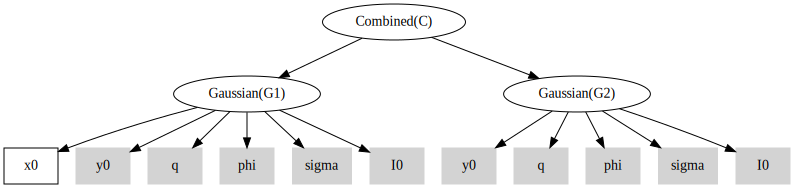

In [8]:
G1 = Gaussian("G1", x0=None, y0=5, q=0.5, phi=0.0, sigma=1.0, I0=1.0)
G2 = Gaussian("G2", x0=5, y0=5, q=0.5, phi=0.0, sigma=1.0, I0=1.0)
C = Combined("C", G1, G2)

del G2.x0 # remove a param from a module

C.graphviz()

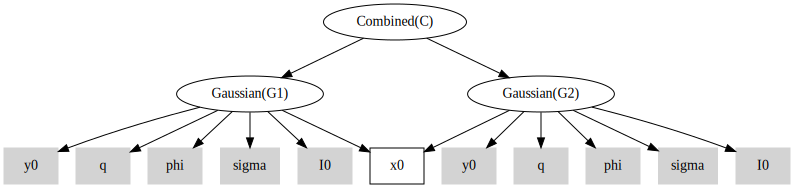

In [9]:
G2.x0 = G1.x0 # assign a param from one module to another
C.graphviz()

## Pointer functions only called once

When you create a pointer function it may be arbitrarily complex, which may require a lot of compute. To maintain efficiency, the pointer is only called once for a given simulation then the value is stored. This shouldn't matter on the user side, but it is just good to know!

In [10]:
class TryCallPointer(ckd.Module):
    def __init__(self):
        super().__init__()
        self.x = ckd.Param("x", 1.0)
        self.y = ckd.Param("y", 2.0)

    @ckd.forward
    def test_call(self):
        total = 0.0
        start = time()
        total += self.x.value
        print(f"first call took {time()-start:.5f} sec")
        start = time()
        total += self.x.value
        print(f"second call took {time()-start:.5f} sec")
        return total
    
def long_function(p):
    sleep(2)
    return 1.0 + p.y.value

T = TryCallPointer()
T.x = long_function
T.x.link(T.y)
print(T.test_call())

first call took 2.00137 sec
second call took 0.00026 sec
tensor(6.)
